# Landslide Detection

## Input : RGB Images
## Output : Risk Zones 

### Procedure :

In case of detecting of sites where landslide , we need to find out area where risk is higher , the images which are used are having 14 channels.

The images are having RGB and one NIR , where Red , Green and Blue , and NIR being Near Infrared Radiation 
We would be utilising this to find the NDVI , i.e the Normalised Difference Vegetative Index , which is used to find the ground or access vegatative index. 

We are having the mask of the probable risk zone , which is used to train a model using the UNET architecture to predict the risk zone on a given Satellite Image


Source of Dataset : Landslide4Sense 


### Importing Tensorflow for Model 

In [1]:
!pip install tensorflow

### Importing Matplotlib for displaying the Plots

In [2]:
!pip install matplotlib

### Importing Pandas for Dataset manipulation 
### Importing Numpy for Numerical Calculations 
### Importing h5py for traversing H5 image format 
### Importing glob for creation of custom image channel 

In [3]:
import pandas as pd
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

In [160]:
# Testing the dataset 
path_single = r"DetectionModel/data/TrainData/img/image_202.h5"
path_single_mask = r'DetectionModel/data/TrainData/mask/mask_202.h5'

# Importing OS
### In order to mount the Dataset

In [4]:
import os

os.listdir('DetectionModel/data/TestData')

['img']

Creating a custom dataset in order to get the slope and elevation from the NDVI , and NIR 


NDVI is found out using the formula : NDVI = NIR - RED / NIR + RED

In the processing of the image , we are denoting the the channel 3 for Red , channel 2 for green and channel 1 for blue , wherese channel 13 is for slope and channel 14 is for the elevation

## RGB Image for training data 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ls ['img']
input data shape: (128, 128, 14)
data ndvi shape  (128, 128) f_data shape:  (1, 128, 128, 3)


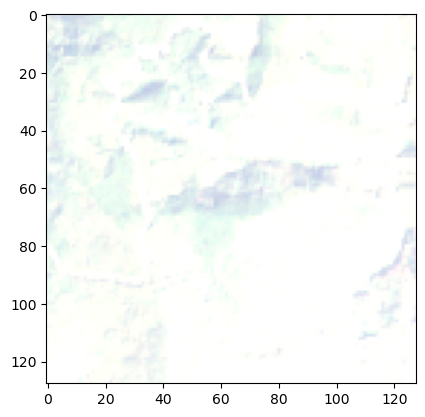

In [203]:
f_data = np.zeros((1, 128,128, 3))
with h5py.File(path_single) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)
    plt.imshow(data[:, :, 3:0:-1])
    
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_rgb = data[:, :, 3:0:-1]
    data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
    f_data[0, :, :, 0] =data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]

    print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
    
    plt.imshow(data_rgb)

## Same image under NDVI condition

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


ls ['img']
input data shape: (128, 128, 14)
data ndvi shape  (128, 128) f_data shape:  (1, 128, 128, 3)


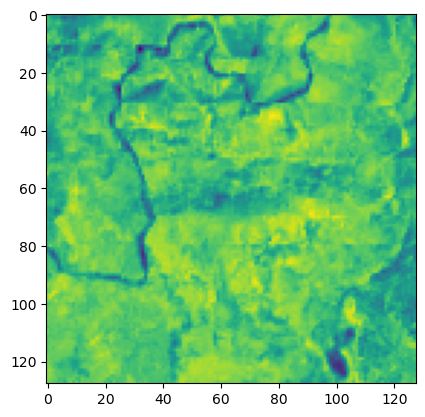

In [204]:
f_data = np.zeros((1, 128,128, 3))
with h5py.File(path_single) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('img'))
    print("input data shape:", data.shape)
    plt.imshow(data[:, :, 3:0:-1])
    
    data_red = data[:, :, 3]
    data_green = data[:, :, 2]
    data_blue = data[:, :, 1]
    data_nir = data[:, :, 7]
    data_rgb = data[:, :, 3:0:-1]
    data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
    f_data[0, :, :, 0] =data_ndvi
    f_data[0, :, :, 1] = data[:, :, 12]
    f_data[0, :, :, 2] = data[:, :, 13]

    print("data ndvi shape ", data_ndvi.shape, "f_data shape: ", f_data.shape)
    
    plt.imshow(data_ndvi)

## Its probable risk Zone

ls ['mask']
input data shape: (128, 128)


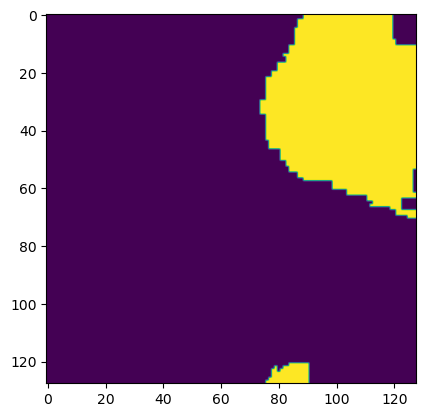

In [162]:
with h5py.File(path_single_mask) as hdf:
    ls = list(hdf.keys())
    print("ls", ls)
    data = np.array(hdf.get('mask'))
    print("input data shape:", data.shape)
    plt.imshow(data)

### Creating Custom dataset with X and Y 


In [168]:
path_single = r"DetectionModel/data/TrainData/img/image_10.h5"
path_single_mask = r'DetectionModel/data/TrainData/mask/mask_10.h5'
TRAIN_PATH = r"DetectionModel/data/TrainData/img/*.h5"
TRAIN_MASK = r'DetectionModel/data/TrainData/mask/*.h5'

TRAIN_XX = np.zeros((3799, 128, 128, 6))
TRAIN_YY = np.zeros((3799, 128, 128, 1))
all_train = sorted(glob.glob(TRAIN_PATH))
all_mask = sorted(glob.glob(TRAIN_MASK))

In [169]:
for i, (img, mask) in enumerate(zip(all_train, all_mask)):
    print(i, img, mask)
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
        
        # final array
        TRAIN_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb  #RED
        TRAIN_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        TRAIN_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        TRAIN_XX[i, :, :, 3] = data_ndvi #NDVI
        TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE
        TRAIN_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION
    
    
    with h5py.File(mask) as hdf:
        ls = list(hdf.keys())
        data=np.array(hdf.get('mask'))
        TRAIN_YY[i, :, :, 0] = data
    

0 DetectionModel/data/TrainData/img\image_1.h5 DetectionModel/data/TrainData/mask\mask_1.h5
1 DetectionModel/data/TrainData/img\image_10.h5 DetectionModel/data/TrainData/mask\mask_10.h5
2 DetectionModel/data/TrainData/img\image_100.h5 DetectionModel/data/TrainData/mask\mask_100.h5
3 DetectionModel/data/TrainData/img\image_1000.h5 DetectionModel/data/TrainData/mask\mask_1000.h5
4 DetectionModel/data/TrainData/img\image_1001.h5 DetectionModel/data/TrainData/mask\mask_1001.h5
5 DetectionModel/data/TrainData/img\image_1002.h5 DetectionModel/data/TrainData/mask\mask_1002.h5
6 DetectionModel/data/TrainData/img\image_1003.h5 DetectionModel/data/TrainData/mask\mask_1003.h5
7 DetectionModel/data/TrainData/img\image_1004.h5 DetectionModel/data/TrainData/mask\mask_1004.h5
8 DetectionModel/data/TrainData/img\image_1005.h5 DetectionModel/data/TrainData/mask\mask_1005.h5
9 DetectionModel/data/TrainData/img\image_1006.h5 DetectionModel/data/TrainData/mask\mask_1006.h5
10 DetectionModel/data/TrainData

85 DetectionModel/data/TrainData/img\image_1075.h5 DetectionModel/data/TrainData/mask\mask_1075.h5
86 DetectionModel/data/TrainData/img\image_1076.h5 DetectionModel/data/TrainData/mask\mask_1076.h5
87 DetectionModel/data/TrainData/img\image_1077.h5 DetectionModel/data/TrainData/mask\mask_1077.h5
88 DetectionModel/data/TrainData/img\image_1078.h5 DetectionModel/data/TrainData/mask\mask_1078.h5
89 DetectionModel/data/TrainData/img\image_1079.h5 DetectionModel/data/TrainData/mask\mask_1079.h5
90 DetectionModel/data/TrainData/img\image_108.h5 DetectionModel/data/TrainData/mask\mask_108.h5
91 DetectionModel/data/TrainData/img\image_1080.h5 DetectionModel/data/TrainData/mask\mask_1080.h5
92 DetectionModel/data/TrainData/img\image_1081.h5 DetectionModel/data/TrainData/mask\mask_1081.h5
93 DetectionModel/data/TrainData/img\image_1082.h5 DetectionModel/data/TrainData/mask\mask_1082.h5
94 DetectionModel/data/TrainData/img\image_1083.h5 DetectionModel/data/TrainData/mask\mask_1083.h5
95 Detection

170 DetectionModel/data/TrainData/img\image_1151.h5 DetectionModel/data/TrainData/mask\mask_1151.h5
171 DetectionModel/data/TrainData/img\image_1152.h5 DetectionModel/data/TrainData/mask\mask_1152.h5
172 DetectionModel/data/TrainData/img\image_1153.h5 DetectionModel/data/TrainData/mask\mask_1153.h5
173 DetectionModel/data/TrainData/img\image_1154.h5 DetectionModel/data/TrainData/mask\mask_1154.h5
174 DetectionModel/data/TrainData/img\image_1155.h5 DetectionModel/data/TrainData/mask\mask_1155.h5
175 DetectionModel/data/TrainData/img\image_1156.h5 DetectionModel/data/TrainData/mask\mask_1156.h5
176 DetectionModel/data/TrainData/img\image_1157.h5 DetectionModel/data/TrainData/mask\mask_1157.h5
177 DetectionModel/data/TrainData/img\image_1158.h5 DetectionModel/data/TrainData/mask\mask_1158.h5
178 DetectionModel/data/TrainData/img\image_1159.h5 DetectionModel/data/TrainData/mask\mask_1159.h5
179 DetectionModel/data/TrainData/img\image_116.h5 DetectionModel/data/TrainData/mask\mask_116.h5
18

258 DetectionModel/data/TrainData/img\image_1230.h5 DetectionModel/data/TrainData/mask\mask_1230.h5
259 DetectionModel/data/TrainData/img\image_1231.h5 DetectionModel/data/TrainData/mask\mask_1231.h5
260 DetectionModel/data/TrainData/img\image_1232.h5 DetectionModel/data/TrainData/mask\mask_1232.h5
261 DetectionModel/data/TrainData/img\image_1233.h5 DetectionModel/data/TrainData/mask\mask_1233.h5
262 DetectionModel/data/TrainData/img\image_1234.h5 DetectionModel/data/TrainData/mask\mask_1234.h5
263 DetectionModel/data/TrainData/img\image_1235.h5 DetectionModel/data/TrainData/mask\mask_1235.h5
264 DetectionModel/data/TrainData/img\image_1236.h5 DetectionModel/data/TrainData/mask\mask_1236.h5
265 DetectionModel/data/TrainData/img\image_1237.h5 DetectionModel/data/TrainData/mask\mask_1237.h5
266 DetectionModel/data/TrainData/img\image_1238.h5 DetectionModel/data/TrainData/mask\mask_1238.h5
267 DetectionModel/data/TrainData/img\image_1239.h5 DetectionModel/data/TrainData/mask\mask_1239.h5


343 DetectionModel/data/TrainData/img\image_1307.h5 DetectionModel/data/TrainData/mask\mask_1307.h5
344 DetectionModel/data/TrainData/img\image_1308.h5 DetectionModel/data/TrainData/mask\mask_1308.h5
345 DetectionModel/data/TrainData/img\image_1309.h5 DetectionModel/data/TrainData/mask\mask_1309.h5
346 DetectionModel/data/TrainData/img\image_131.h5 DetectionModel/data/TrainData/mask\mask_131.h5
347 DetectionModel/data/TrainData/img\image_1310.h5 DetectionModel/data/TrainData/mask\mask_1310.h5
348 DetectionModel/data/TrainData/img\image_1311.h5 DetectionModel/data/TrainData/mask\mask_1311.h5
349 DetectionModel/data/TrainData/img\image_1312.h5 DetectionModel/data/TrainData/mask\mask_1312.h5
350 DetectionModel/data/TrainData/img\image_1313.h5 DetectionModel/data/TrainData/mask\mask_1313.h5
351 DetectionModel/data/TrainData/img\image_1314.h5 DetectionModel/data/TrainData/mask\mask_1314.h5
352 DetectionModel/data/TrainData/img\image_1315.h5 DetectionModel/data/TrainData/mask\mask_1315.h5
35

432 DetectionModel/data/TrainData/img\image_1388.h5 DetectionModel/data/TrainData/mask\mask_1388.h5
433 DetectionModel/data/TrainData/img\image_1389.h5 DetectionModel/data/TrainData/mask\mask_1389.h5
434 DetectionModel/data/TrainData/img\image_139.h5 DetectionModel/data/TrainData/mask\mask_139.h5
435 DetectionModel/data/TrainData/img\image_1390.h5 DetectionModel/data/TrainData/mask\mask_1390.h5
436 DetectionModel/data/TrainData/img\image_1391.h5 DetectionModel/data/TrainData/mask\mask_1391.h5
437 DetectionModel/data/TrainData/img\image_1392.h5 DetectionModel/data/TrainData/mask\mask_1392.h5
438 DetectionModel/data/TrainData/img\image_1393.h5 DetectionModel/data/TrainData/mask\mask_1393.h5
439 DetectionModel/data/TrainData/img\image_1394.h5 DetectionModel/data/TrainData/mask\mask_1394.h5
440 DetectionModel/data/TrainData/img\image_1395.h5 DetectionModel/data/TrainData/mask\mask_1395.h5
441 DetectionModel/data/TrainData/img\image_1396.h5 DetectionModel/data/TrainData/mask\mask_1396.h5
44

520 DetectionModel/data/TrainData/img\image_1467.h5 DetectionModel/data/TrainData/mask\mask_1467.h5
521 DetectionModel/data/TrainData/img\image_1468.h5 DetectionModel/data/TrainData/mask\mask_1468.h5
522 DetectionModel/data/TrainData/img\image_1469.h5 DetectionModel/data/TrainData/mask\mask_1469.h5
523 DetectionModel/data/TrainData/img\image_147.h5 DetectionModel/data/TrainData/mask\mask_147.h5
524 DetectionModel/data/TrainData/img\image_1470.h5 DetectionModel/data/TrainData/mask\mask_1470.h5
525 DetectionModel/data/TrainData/img\image_1471.h5 DetectionModel/data/TrainData/mask\mask_1471.h5
526 DetectionModel/data/TrainData/img\image_1472.h5 DetectionModel/data/TrainData/mask\mask_1472.h5
527 DetectionModel/data/TrainData/img\image_1473.h5 DetectionModel/data/TrainData/mask\mask_1473.h5
528 DetectionModel/data/TrainData/img\image_1474.h5 DetectionModel/data/TrainData/mask\mask_1474.h5
529 DetectionModel/data/TrainData/img\image_1475.h5 DetectionModel/data/TrainData/mask\mask_1475.h5
53

609 DetectionModel/data/TrainData/img\image_1547.h5 DetectionModel/data/TrainData/mask\mask_1547.h5
610 DetectionModel/data/TrainData/img\image_1548.h5 DetectionModel/data/TrainData/mask\mask_1548.h5
611 DetectionModel/data/TrainData/img\image_1549.h5 DetectionModel/data/TrainData/mask\mask_1549.h5
612 DetectionModel/data/TrainData/img\image_155.h5 DetectionModel/data/TrainData/mask\mask_155.h5
613 DetectionModel/data/TrainData/img\image_1550.h5 DetectionModel/data/TrainData/mask\mask_1550.h5
614 DetectionModel/data/TrainData/img\image_1551.h5 DetectionModel/data/TrainData/mask\mask_1551.h5
615 DetectionModel/data/TrainData/img\image_1552.h5 DetectionModel/data/TrainData/mask\mask_1552.h5
616 DetectionModel/data/TrainData/img\image_1553.h5 DetectionModel/data/TrainData/mask\mask_1553.h5
617 DetectionModel/data/TrainData/img\image_1554.h5 DetectionModel/data/TrainData/mask\mask_1554.h5
618 DetectionModel/data/TrainData/img\image_1555.h5 DetectionModel/data/TrainData/mask\mask_1555.h5
61

692 DetectionModel/data/TrainData/img\image_1621.h5 DetectionModel/data/TrainData/mask\mask_1621.h5
693 DetectionModel/data/TrainData/img\image_1622.h5 DetectionModel/data/TrainData/mask\mask_1622.h5
694 DetectionModel/data/TrainData/img\image_1623.h5 DetectionModel/data/TrainData/mask\mask_1623.h5
695 DetectionModel/data/TrainData/img\image_1624.h5 DetectionModel/data/TrainData/mask\mask_1624.h5
696 DetectionModel/data/TrainData/img\image_1625.h5 DetectionModel/data/TrainData/mask\mask_1625.h5
697 DetectionModel/data/TrainData/img\image_1626.h5 DetectionModel/data/TrainData/mask\mask_1626.h5
698 DetectionModel/data/TrainData/img\image_1627.h5 DetectionModel/data/TrainData/mask\mask_1627.h5
699 DetectionModel/data/TrainData/img\image_1628.h5 DetectionModel/data/TrainData/mask\mask_1628.h5
700 DetectionModel/data/TrainData/img\image_1629.h5 DetectionModel/data/TrainData/mask\mask_1629.h5
701 DetectionModel/data/TrainData/img\image_163.h5 DetectionModel/data/TrainData/mask\mask_163.h5
70

781 DetectionModel/data/TrainData/img\image_1701.h5 DetectionModel/data/TrainData/mask\mask_1701.h5
782 DetectionModel/data/TrainData/img\image_1702.h5 DetectionModel/data/TrainData/mask\mask_1702.h5
783 DetectionModel/data/TrainData/img\image_1703.h5 DetectionModel/data/TrainData/mask\mask_1703.h5
784 DetectionModel/data/TrainData/img\image_1704.h5 DetectionModel/data/TrainData/mask\mask_1704.h5
785 DetectionModel/data/TrainData/img\image_1705.h5 DetectionModel/data/TrainData/mask\mask_1705.h5
786 DetectionModel/data/TrainData/img\image_1706.h5 DetectionModel/data/TrainData/mask\mask_1706.h5
787 DetectionModel/data/TrainData/img\image_1707.h5 DetectionModel/data/TrainData/mask\mask_1707.h5
788 DetectionModel/data/TrainData/img\image_1708.h5 DetectionModel/data/TrainData/mask\mask_1708.h5
789 DetectionModel/data/TrainData/img\image_1709.h5 DetectionModel/data/TrainData/mask\mask_1709.h5
790 DetectionModel/data/TrainData/img\image_171.h5 DetectionModel/data/TrainData/mask\mask_171.h5
79

869 DetectionModel/data/TrainData/img\image_1781.h5 DetectionModel/data/TrainData/mask\mask_1781.h5
870 DetectionModel/data/TrainData/img\image_1782.h5 DetectionModel/data/TrainData/mask\mask_1782.h5
871 DetectionModel/data/TrainData/img\image_1783.h5 DetectionModel/data/TrainData/mask\mask_1783.h5
872 DetectionModel/data/TrainData/img\image_1784.h5 DetectionModel/data/TrainData/mask\mask_1784.h5
873 DetectionModel/data/TrainData/img\image_1785.h5 DetectionModel/data/TrainData/mask\mask_1785.h5
874 DetectionModel/data/TrainData/img\image_1786.h5 DetectionModel/data/TrainData/mask\mask_1786.h5
875 DetectionModel/data/TrainData/img\image_1787.h5 DetectionModel/data/TrainData/mask\mask_1787.h5
876 DetectionModel/data/TrainData/img\image_1788.h5 DetectionModel/data/TrainData/mask\mask_1788.h5
877 DetectionModel/data/TrainData/img\image_1789.h5 DetectionModel/data/TrainData/mask\mask_1789.h5
878 DetectionModel/data/TrainData/img\image_179.h5 DetectionModel/data/TrainData/mask\mask_179.h5
87

953 DetectionModel/data/TrainData/img\image_1857.h5 DetectionModel/data/TrainData/mask\mask_1857.h5
954 DetectionModel/data/TrainData/img\image_1858.h5 DetectionModel/data/TrainData/mask\mask_1858.h5
955 DetectionModel/data/TrainData/img\image_1859.h5 DetectionModel/data/TrainData/mask\mask_1859.h5
956 DetectionModel/data/TrainData/img\image_186.h5 DetectionModel/data/TrainData/mask\mask_186.h5
957 DetectionModel/data/TrainData/img\image_1860.h5 DetectionModel/data/TrainData/mask\mask_1860.h5
958 DetectionModel/data/TrainData/img\image_1861.h5 DetectionModel/data/TrainData/mask\mask_1861.h5
959 DetectionModel/data/TrainData/img\image_1862.h5 DetectionModel/data/TrainData/mask\mask_1862.h5
960 DetectionModel/data/TrainData/img\image_1863.h5 DetectionModel/data/TrainData/mask\mask_1863.h5
961 DetectionModel/data/TrainData/img\image_1864.h5 DetectionModel/data/TrainData/mask\mask_1864.h5
962 DetectionModel/data/TrainData/img\image_1865.h5 DetectionModel/data/TrainData/mask\mask_1865.h5
96

1040 DetectionModel/data/TrainData/img\image_1935.h5 DetectionModel/data/TrainData/mask\mask_1935.h5
1041 DetectionModel/data/TrainData/img\image_1936.h5 DetectionModel/data/TrainData/mask\mask_1936.h5
1042 DetectionModel/data/TrainData/img\image_1937.h5 DetectionModel/data/TrainData/mask\mask_1937.h5
1043 DetectionModel/data/TrainData/img\image_1938.h5 DetectionModel/data/TrainData/mask\mask_1938.h5
1044 DetectionModel/data/TrainData/img\image_1939.h5 DetectionModel/data/TrainData/mask\mask_1939.h5
1045 DetectionModel/data/TrainData/img\image_194.h5 DetectionModel/data/TrainData/mask\mask_194.h5
1046 DetectionModel/data/TrainData/img\image_1940.h5 DetectionModel/data/TrainData/mask\mask_1940.h5
1047 DetectionModel/data/TrainData/img\image_1941.h5 DetectionModel/data/TrainData/mask\mask_1941.h5
1048 DetectionModel/data/TrainData/img\image_1942.h5 DetectionModel/data/TrainData/mask\mask_1942.h5
1049 DetectionModel/data/TrainData/img\image_1943.h5 DetectionModel/data/TrainData/mask\mask_

1129 DetectionModel/data/TrainData/img\image_2014.h5 DetectionModel/data/TrainData/mask\mask_2014.h5
1130 DetectionModel/data/TrainData/img\image_2015.h5 DetectionModel/data/TrainData/mask\mask_2015.h5
1131 DetectionModel/data/TrainData/img\image_2016.h5 DetectionModel/data/TrainData/mask\mask_2016.h5
1132 DetectionModel/data/TrainData/img\image_2017.h5 DetectionModel/data/TrainData/mask\mask_2017.h5
1133 DetectionModel/data/TrainData/img\image_2018.h5 DetectionModel/data/TrainData/mask\mask_2018.h5
1134 DetectionModel/data/TrainData/img\image_2019.h5 DetectionModel/data/TrainData/mask\mask_2019.h5
1135 DetectionModel/data/TrainData/img\image_202.h5 DetectionModel/data/TrainData/mask\mask_202.h5
1136 DetectionModel/data/TrainData/img\image_2020.h5 DetectionModel/data/TrainData/mask\mask_2020.h5
1137 DetectionModel/data/TrainData/img\image_2021.h5 DetectionModel/data/TrainData/mask\mask_2021.h5
1138 DetectionModel/data/TrainData/img\image_2022.h5 DetectionModel/data/TrainData/mask\mask_

1214 DetectionModel/data/TrainData/img\image_2091.h5 DetectionModel/data/TrainData/mask\mask_2091.h5
1215 DetectionModel/data/TrainData/img\image_2092.h5 DetectionModel/data/TrainData/mask\mask_2092.h5
1216 DetectionModel/data/TrainData/img\image_2093.h5 DetectionModel/data/TrainData/mask\mask_2093.h5
1217 DetectionModel/data/TrainData/img\image_2094.h5 DetectionModel/data/TrainData/mask\mask_2094.h5
1218 DetectionModel/data/TrainData/img\image_2095.h5 DetectionModel/data/TrainData/mask\mask_2095.h5
1219 DetectionModel/data/TrainData/img\image_2096.h5 DetectionModel/data/TrainData/mask\mask_2096.h5
1220 DetectionModel/data/TrainData/img\image_2097.h5 DetectionModel/data/TrainData/mask\mask_2097.h5
1221 DetectionModel/data/TrainData/img\image_2098.h5 DetectionModel/data/TrainData/mask\mask_2098.h5
1222 DetectionModel/data/TrainData/img\image_2099.h5 DetectionModel/data/TrainData/mask\mask_2099.h5
1223 DetectionModel/data/TrainData/img\image_21.h5 DetectionModel/data/TrainData/mask\mask_

1302 DetectionModel/data/TrainData/img\image_2170.h5 DetectionModel/data/TrainData/mask\mask_2170.h5
1303 DetectionModel/data/TrainData/img\image_2171.h5 DetectionModel/data/TrainData/mask\mask_2171.h5
1304 DetectionModel/data/TrainData/img\image_2172.h5 DetectionModel/data/TrainData/mask\mask_2172.h5
1305 DetectionModel/data/TrainData/img\image_2173.h5 DetectionModel/data/TrainData/mask\mask_2173.h5
1306 DetectionModel/data/TrainData/img\image_2174.h5 DetectionModel/data/TrainData/mask\mask_2174.h5
1307 DetectionModel/data/TrainData/img\image_2175.h5 DetectionModel/data/TrainData/mask\mask_2175.h5
1308 DetectionModel/data/TrainData/img\image_2176.h5 DetectionModel/data/TrainData/mask\mask_2176.h5
1309 DetectionModel/data/TrainData/img\image_2177.h5 DetectionModel/data/TrainData/mask\mask_2177.h5
1310 DetectionModel/data/TrainData/img\image_2178.h5 DetectionModel/data/TrainData/mask\mask_2178.h5
1311 DetectionModel/data/TrainData/img\image_2179.h5 DetectionModel/data/TrainData/mask\mas

1390 DetectionModel/data/TrainData/img\image_225.h5 DetectionModel/data/TrainData/mask\mask_225.h5
1391 DetectionModel/data/TrainData/img\image_2250.h5 DetectionModel/data/TrainData/mask\mask_2250.h5
1392 DetectionModel/data/TrainData/img\image_2251.h5 DetectionModel/data/TrainData/mask\mask_2251.h5
1393 DetectionModel/data/TrainData/img\image_2252.h5 DetectionModel/data/TrainData/mask\mask_2252.h5
1394 DetectionModel/data/TrainData/img\image_2253.h5 DetectionModel/data/TrainData/mask\mask_2253.h5
1395 DetectionModel/data/TrainData/img\image_2254.h5 DetectionModel/data/TrainData/mask\mask_2254.h5
1396 DetectionModel/data/TrainData/img\image_2255.h5 DetectionModel/data/TrainData/mask\mask_2255.h5
1397 DetectionModel/data/TrainData/img\image_2256.h5 DetectionModel/data/TrainData/mask\mask_2256.h5
1398 DetectionModel/data/TrainData/img\image_2257.h5 DetectionModel/data/TrainData/mask\mask_2257.h5
1399 DetectionModel/data/TrainData/img\image_2258.h5 DetectionModel/data/TrainData/mask\mask_

1472 DetectionModel/data/TrainData/img\image_2323.h5 DetectionModel/data/TrainData/mask\mask_2323.h5
1473 DetectionModel/data/TrainData/img\image_2324.h5 DetectionModel/data/TrainData/mask\mask_2324.h5
1474 DetectionModel/data/TrainData/img\image_2325.h5 DetectionModel/data/TrainData/mask\mask_2325.h5
1475 DetectionModel/data/TrainData/img\image_2326.h5 DetectionModel/data/TrainData/mask\mask_2326.h5
1476 DetectionModel/data/TrainData/img\image_2327.h5 DetectionModel/data/TrainData/mask\mask_2327.h5
1477 DetectionModel/data/TrainData/img\image_2328.h5 DetectionModel/data/TrainData/mask\mask_2328.h5
1478 DetectionModel/data/TrainData/img\image_2329.h5 DetectionModel/data/TrainData/mask\mask_2329.h5
1479 DetectionModel/data/TrainData/img\image_233.h5 DetectionModel/data/TrainData/mask\mask_233.h5
1480 DetectionModel/data/TrainData/img\image_2330.h5 DetectionModel/data/TrainData/mask\mask_2330.h5
1481 DetectionModel/data/TrainData/img\image_2331.h5 DetectionModel/data/TrainData/mask\mask_

1556 DetectionModel/data/TrainData/img\image_24.h5 DetectionModel/data/TrainData/mask\mask_24.h5
1557 DetectionModel/data/TrainData/img\image_240.h5 DetectionModel/data/TrainData/mask\mask_240.h5
1558 DetectionModel/data/TrainData/img\image_2400.h5 DetectionModel/data/TrainData/mask\mask_2400.h5
1559 DetectionModel/data/TrainData/img\image_2401.h5 DetectionModel/data/TrainData/mask\mask_2401.h5
1560 DetectionModel/data/TrainData/img\image_2402.h5 DetectionModel/data/TrainData/mask\mask_2402.h5
1561 DetectionModel/data/TrainData/img\image_2403.h5 DetectionModel/data/TrainData/mask\mask_2403.h5
1562 DetectionModel/data/TrainData/img\image_2404.h5 DetectionModel/data/TrainData/mask\mask_2404.h5
1563 DetectionModel/data/TrainData/img\image_2405.h5 DetectionModel/data/TrainData/mask\mask_2405.h5
1564 DetectionModel/data/TrainData/img\image_2406.h5 DetectionModel/data/TrainData/mask\mask_2406.h5
1565 DetectionModel/data/TrainData/img\image_2407.h5 DetectionModel/data/TrainData/mask\mask_2407

1640 DetectionModel/data/TrainData/img\image_2475.h5 DetectionModel/data/TrainData/mask\mask_2475.h5
1641 DetectionModel/data/TrainData/img\image_2476.h5 DetectionModel/data/TrainData/mask\mask_2476.h5
1642 DetectionModel/data/TrainData/img\image_2477.h5 DetectionModel/data/TrainData/mask\mask_2477.h5
1643 DetectionModel/data/TrainData/img\image_2478.h5 DetectionModel/data/TrainData/mask\mask_2478.h5
1644 DetectionModel/data/TrainData/img\image_2479.h5 DetectionModel/data/TrainData/mask\mask_2479.h5
1645 DetectionModel/data/TrainData/img\image_248.h5 DetectionModel/data/TrainData/mask\mask_248.h5
1646 DetectionModel/data/TrainData/img\image_2480.h5 DetectionModel/data/TrainData/mask\mask_2480.h5
1647 DetectionModel/data/TrainData/img\image_2481.h5 DetectionModel/data/TrainData/mask\mask_2481.h5
1648 DetectionModel/data/TrainData/img\image_2482.h5 DetectionModel/data/TrainData/mask\mask_2482.h5
1649 DetectionModel/data/TrainData/img\image_2483.h5 DetectionModel/data/TrainData/mask\mask_

C:\Users\HP\AppData\Local\Temp\ipykernel_11128\3444182847.py:25: RuntimeWarning: invalid value encountered in divide
  TRAIN_XX[i, :, :, 4] = 1 - data[:, :, 12] / mid_slope #SLOPE


1670 DetectionModel/data/TrainData/img\image_2501.h5 DetectionModel/data/TrainData/mask\mask_2501.h5
1671 DetectionModel/data/TrainData/img\image_2502.h5 DetectionModel/data/TrainData/mask\mask_2502.h5
1672 DetectionModel/data/TrainData/img\image_2503.h5 DetectionModel/data/TrainData/mask\mask_2503.h5
1673 DetectionModel/data/TrainData/img\image_2504.h5 DetectionModel/data/TrainData/mask\mask_2504.h5
1674 DetectionModel/data/TrainData/img\image_2505.h5 DetectionModel/data/TrainData/mask\mask_2505.h5
1675 DetectionModel/data/TrainData/img\image_2506.h5 DetectionModel/data/TrainData/mask\mask_2506.h5
1676 DetectionModel/data/TrainData/img\image_2507.h5 DetectionModel/data/TrainData/mask\mask_2507.h5
1677 DetectionModel/data/TrainData/img\image_2508.h5 DetectionModel/data/TrainData/mask\mask_2508.h5
1678 DetectionModel/data/TrainData/img\image_2509.h5 DetectionModel/data/TrainData/mask\mask_2509.h5
1679 DetectionModel/data/TrainData/img\image_251.h5 DetectionModel/data/TrainData/mask\mask

1752 DetectionModel/data/TrainData/img\image_2576.h5 DetectionModel/data/TrainData/mask\mask_2576.h5
1753 DetectionModel/data/TrainData/img\image_2577.h5 DetectionModel/data/TrainData/mask\mask_2577.h5
1754 DetectionModel/data/TrainData/img\image_2578.h5 DetectionModel/data/TrainData/mask\mask_2578.h5
1755 DetectionModel/data/TrainData/img\image_2579.h5 DetectionModel/data/TrainData/mask\mask_2579.h5
1756 DetectionModel/data/TrainData/img\image_258.h5 DetectionModel/data/TrainData/mask\mask_258.h5
1757 DetectionModel/data/TrainData/img\image_2580.h5 DetectionModel/data/TrainData/mask\mask_2580.h5
1758 DetectionModel/data/TrainData/img\image_2581.h5 DetectionModel/data/TrainData/mask\mask_2581.h5
1759 DetectionModel/data/TrainData/img\image_2582.h5 DetectionModel/data/TrainData/mask\mask_2582.h5
1760 DetectionModel/data/TrainData/img\image_2583.h5 DetectionModel/data/TrainData/mask\mask_2583.h5
1761 DetectionModel/data/TrainData/img\image_2584.h5 DetectionModel/data/TrainData/mask\mask_

1835 DetectionModel/data/TrainData/img\image_2650.h5 DetectionModel/data/TrainData/mask\mask_2650.h5
1836 DetectionModel/data/TrainData/img\image_2651.h5 DetectionModel/data/TrainData/mask\mask_2651.h5
1837 DetectionModel/data/TrainData/img\image_2652.h5 DetectionModel/data/TrainData/mask\mask_2652.h5
1838 DetectionModel/data/TrainData/img\image_2653.h5 DetectionModel/data/TrainData/mask\mask_2653.h5
1839 DetectionModel/data/TrainData/img\image_2654.h5 DetectionModel/data/TrainData/mask\mask_2654.h5
1840 DetectionModel/data/TrainData/img\image_2655.h5 DetectionModel/data/TrainData/mask\mask_2655.h5
1841 DetectionModel/data/TrainData/img\image_2656.h5 DetectionModel/data/TrainData/mask\mask_2656.h5
1842 DetectionModel/data/TrainData/img\image_2657.h5 DetectionModel/data/TrainData/mask\mask_2657.h5
1843 DetectionModel/data/TrainData/img\image_2658.h5 DetectionModel/data/TrainData/mask\mask_2658.h5
1844 DetectionModel/data/TrainData/img\image_2659.h5 DetectionModel/data/TrainData/mask\mas

1925 DetectionModel/data/TrainData/img\image_2731.h5 DetectionModel/data/TrainData/mask\mask_2731.h5
1926 DetectionModel/data/TrainData/img\image_2732.h5 DetectionModel/data/TrainData/mask\mask_2732.h5
1927 DetectionModel/data/TrainData/img\image_2733.h5 DetectionModel/data/TrainData/mask\mask_2733.h5
1928 DetectionModel/data/TrainData/img\image_2734.h5 DetectionModel/data/TrainData/mask\mask_2734.h5
1929 DetectionModel/data/TrainData/img\image_2735.h5 DetectionModel/data/TrainData/mask\mask_2735.h5
1930 DetectionModel/data/TrainData/img\image_2736.h5 DetectionModel/data/TrainData/mask\mask_2736.h5
1931 DetectionModel/data/TrainData/img\image_2737.h5 DetectionModel/data/TrainData/mask\mask_2737.h5
1932 DetectionModel/data/TrainData/img\image_2738.h5 DetectionModel/data/TrainData/mask\mask_2738.h5
1933 DetectionModel/data/TrainData/img\image_2739.h5 DetectionModel/data/TrainData/mask\mask_2739.h5
1934 DetectionModel/data/TrainData/img\image_274.h5 DetectionModel/data/TrainData/mask\mask

2008 DetectionModel/data/TrainData/img\image_2806.h5 DetectionModel/data/TrainData/mask\mask_2806.h5
2009 DetectionModel/data/TrainData/img\image_2807.h5 DetectionModel/data/TrainData/mask\mask_2807.h5
2010 DetectionModel/data/TrainData/img\image_2808.h5 DetectionModel/data/TrainData/mask\mask_2808.h5
2011 DetectionModel/data/TrainData/img\image_2809.h5 DetectionModel/data/TrainData/mask\mask_2809.h5
2012 DetectionModel/data/TrainData/img\image_281.h5 DetectionModel/data/TrainData/mask\mask_281.h5
2013 DetectionModel/data/TrainData/img\image_2810.h5 DetectionModel/data/TrainData/mask\mask_2810.h5
2014 DetectionModel/data/TrainData/img\image_2811.h5 DetectionModel/data/TrainData/mask\mask_2811.h5
2015 DetectionModel/data/TrainData/img\image_2812.h5 DetectionModel/data/TrainData/mask\mask_2812.h5
2016 DetectionModel/data/TrainData/img\image_2813.h5 DetectionModel/data/TrainData/mask\mask_2813.h5
2017 DetectionModel/data/TrainData/img\image_2814.h5 DetectionModel/data/TrainData/mask\mask_

2096 DetectionModel/data/TrainData/img\image_2886.h5 DetectionModel/data/TrainData/mask\mask_2886.h5
2097 DetectionModel/data/TrainData/img\image_2887.h5 DetectionModel/data/TrainData/mask\mask_2887.h5
2098 DetectionModel/data/TrainData/img\image_2888.h5 DetectionModel/data/TrainData/mask\mask_2888.h5
2099 DetectionModel/data/TrainData/img\image_2889.h5 DetectionModel/data/TrainData/mask\mask_2889.h5
2100 DetectionModel/data/TrainData/img\image_289.h5 DetectionModel/data/TrainData/mask\mask_289.h5
2101 DetectionModel/data/TrainData/img\image_2890.h5 DetectionModel/data/TrainData/mask\mask_2890.h5
2102 DetectionModel/data/TrainData/img\image_2891.h5 DetectionModel/data/TrainData/mask\mask_2891.h5
2103 DetectionModel/data/TrainData/img\image_2892.h5 DetectionModel/data/TrainData/mask\mask_2892.h5
2104 DetectionModel/data/TrainData/img\image_2893.h5 DetectionModel/data/TrainData/mask\mask_2893.h5
2105 DetectionModel/data/TrainData/img\image_2894.h5 DetectionModel/data/TrainData/mask\mask_

2186 DetectionModel/data/TrainData/img\image_2967.h5 DetectionModel/data/TrainData/mask\mask_2967.h5
2187 DetectionModel/data/TrainData/img\image_2968.h5 DetectionModel/data/TrainData/mask\mask_2968.h5
2188 DetectionModel/data/TrainData/img\image_2969.h5 DetectionModel/data/TrainData/mask\mask_2969.h5
2189 DetectionModel/data/TrainData/img\image_297.h5 DetectionModel/data/TrainData/mask\mask_297.h5
2190 DetectionModel/data/TrainData/img\image_2970.h5 DetectionModel/data/TrainData/mask\mask_2970.h5
2191 DetectionModel/data/TrainData/img\image_2971.h5 DetectionModel/data/TrainData/mask\mask_2971.h5
2192 DetectionModel/data/TrainData/img\image_2972.h5 DetectionModel/data/TrainData/mask\mask_2972.h5
2193 DetectionModel/data/TrainData/img\image_2973.h5 DetectionModel/data/TrainData/mask\mask_2973.h5
2194 DetectionModel/data/TrainData/img\image_2974.h5 DetectionModel/data/TrainData/mask\mask_2974.h5
2195 DetectionModel/data/TrainData/img\image_2975.h5 DetectionModel/data/TrainData/mask\mask_

C:\Users\HP\AppData\Local\Temp\ipykernel_11128\3444182847.py:18: RuntimeWarning: invalid value encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))


2270 DetectionModel/data/TrainData/img\image_3041.h5 DetectionModel/data/TrainData/mask\mask_3041.h5
2271 DetectionModel/data/TrainData/img\image_3042.h5 DetectionModel/data/TrainData/mask\mask_3042.h5
2272 DetectionModel/data/TrainData/img\image_3043.h5 DetectionModel/data/TrainData/mask\mask_3043.h5
2273 DetectionModel/data/TrainData/img\image_3044.h5 DetectionModel/data/TrainData/mask\mask_3044.h5
2274 DetectionModel/data/TrainData/img\image_3045.h5 DetectionModel/data/TrainData/mask\mask_3045.h5
2275 DetectionModel/data/TrainData/img\image_3046.h5 DetectionModel/data/TrainData/mask\mask_3046.h5
2276 DetectionModel/data/TrainData/img\image_3047.h5 DetectionModel/data/TrainData/mask\mask_3047.h5
2277 DetectionModel/data/TrainData/img\image_3048.h5 DetectionModel/data/TrainData/mask\mask_3048.h5
2278 DetectionModel/data/TrainData/img\image_3049.h5 DetectionModel/data/TrainData/mask\mask_3049.h5
2279 DetectionModel/data/TrainData/img\image_305.h5 DetectionModel/data/TrainData/mask\mask

2352 DetectionModel/data/TrainData/img\image_3115.h5 DetectionModel/data/TrainData/mask\mask_3115.h5
2353 DetectionModel/data/TrainData/img\image_3116.h5 DetectionModel/data/TrainData/mask\mask_3116.h5
2354 DetectionModel/data/TrainData/img\image_3117.h5 DetectionModel/data/TrainData/mask\mask_3117.h5
2355 DetectionModel/data/TrainData/img\image_3118.h5 DetectionModel/data/TrainData/mask\mask_3118.h5
2356 DetectionModel/data/TrainData/img\image_3119.h5 DetectionModel/data/TrainData/mask\mask_3119.h5
2357 DetectionModel/data/TrainData/img\image_312.h5 DetectionModel/data/TrainData/mask\mask_312.h5
2358 DetectionModel/data/TrainData/img\image_3120.h5 DetectionModel/data/TrainData/mask\mask_3120.h5
2359 DetectionModel/data/TrainData/img\image_3121.h5 DetectionModel/data/TrainData/mask\mask_3121.h5
2360 DetectionModel/data/TrainData/img\image_3122.h5 DetectionModel/data/TrainData/mask\mask_3122.h5
2361 DetectionModel/data/TrainData/img\image_3123.h5 DetectionModel/data/TrainData/mask\mask_

2439 DetectionModel/data/TrainData/img\image_3194.h5 DetectionModel/data/TrainData/mask\mask_3194.h5
2440 DetectionModel/data/TrainData/img\image_3195.h5 DetectionModel/data/TrainData/mask\mask_3195.h5
2441 DetectionModel/data/TrainData/img\image_3196.h5 DetectionModel/data/TrainData/mask\mask_3196.h5
2442 DetectionModel/data/TrainData/img\image_3197.h5 DetectionModel/data/TrainData/mask\mask_3197.h5
2443 DetectionModel/data/TrainData/img\image_3198.h5 DetectionModel/data/TrainData/mask\mask_3198.h5
2444 DetectionModel/data/TrainData/img\image_3199.h5 DetectionModel/data/TrainData/mask\mask_3199.h5
2445 DetectionModel/data/TrainData/img\image_32.h5 DetectionModel/data/TrainData/mask\mask_32.h5
2446 DetectionModel/data/TrainData/img\image_320.h5 DetectionModel/data/TrainData/mask\mask_320.h5
2447 DetectionModel/data/TrainData/img\image_3200.h5 DetectionModel/data/TrainData/mask\mask_3200.h5
2448 DetectionModel/data/TrainData/img\image_3201.h5 DetectionModel/data/TrainData/mask\mask_3201

2523 DetectionModel/data/TrainData/img\image_327.h5 DetectionModel/data/TrainData/mask\mask_327.h5
2524 DetectionModel/data/TrainData/img\image_3270.h5 DetectionModel/data/TrainData/mask\mask_3270.h5
2525 DetectionModel/data/TrainData/img\image_3271.h5 DetectionModel/data/TrainData/mask\mask_3271.h5
2526 DetectionModel/data/TrainData/img\image_3272.h5 DetectionModel/data/TrainData/mask\mask_3272.h5
2527 DetectionModel/data/TrainData/img\image_3273.h5 DetectionModel/data/TrainData/mask\mask_3273.h5
2528 DetectionModel/data/TrainData/img\image_3274.h5 DetectionModel/data/TrainData/mask\mask_3274.h5
2529 DetectionModel/data/TrainData/img\image_3275.h5 DetectionModel/data/TrainData/mask\mask_3275.h5
2530 DetectionModel/data/TrainData/img\image_3276.h5 DetectionModel/data/TrainData/mask\mask_3276.h5
2531 DetectionModel/data/TrainData/img\image_3277.h5 DetectionModel/data/TrainData/mask\mask_3277.h5
2532 DetectionModel/data/TrainData/img\image_3278.h5 DetectionModel/data/TrainData/mask\mask_

2608 DetectionModel/data/TrainData/img\image_3346.h5 DetectionModel/data/TrainData/mask\mask_3346.h5
2609 DetectionModel/data/TrainData/img\image_3347.h5 DetectionModel/data/TrainData/mask\mask_3347.h5
2610 DetectionModel/data/TrainData/img\image_3348.h5 DetectionModel/data/TrainData/mask\mask_3348.h5
2611 DetectionModel/data/TrainData/img\image_3349.h5 DetectionModel/data/TrainData/mask\mask_3349.h5
2612 DetectionModel/data/TrainData/img\image_335.h5 DetectionModel/data/TrainData/mask\mask_335.h5
2613 DetectionModel/data/TrainData/img\image_3350.h5 DetectionModel/data/TrainData/mask\mask_3350.h5
2614 DetectionModel/data/TrainData/img\image_3351.h5 DetectionModel/data/TrainData/mask\mask_3351.h5
2615 DetectionModel/data/TrainData/img\image_3352.h5 DetectionModel/data/TrainData/mask\mask_3352.h5
2616 DetectionModel/data/TrainData/img\image_3353.h5 DetectionModel/data/TrainData/mask\mask_3353.h5
2617 DetectionModel/data/TrainData/img\image_3354.h5 DetectionModel/data/TrainData/mask\mask_

2690 DetectionModel/data/TrainData/img\image_342.h5 DetectionModel/data/TrainData/mask\mask_342.h5
2691 DetectionModel/data/TrainData/img\image_3420.h5 DetectionModel/data/TrainData/mask\mask_3420.h5
2692 DetectionModel/data/TrainData/img\image_3421.h5 DetectionModel/data/TrainData/mask\mask_3421.h5
2693 DetectionModel/data/TrainData/img\image_3422.h5 DetectionModel/data/TrainData/mask\mask_3422.h5
2694 DetectionModel/data/TrainData/img\image_3423.h5 DetectionModel/data/TrainData/mask\mask_3423.h5
2695 DetectionModel/data/TrainData/img\image_3424.h5 DetectionModel/data/TrainData/mask\mask_3424.h5
2696 DetectionModel/data/TrainData/img\image_3425.h5 DetectionModel/data/TrainData/mask\mask_3425.h5
2697 DetectionModel/data/TrainData/img\image_3426.h5 DetectionModel/data/TrainData/mask\mask_3426.h5
2698 DetectionModel/data/TrainData/img\image_3427.h5 DetectionModel/data/TrainData/mask\mask_3427.h5
2699 DetectionModel/data/TrainData/img\image_3428.h5 DetectionModel/data/TrainData/mask\mask_

2777 DetectionModel/data/TrainData/img\image_3499.h5 DetectionModel/data/TrainData/mask\mask_3499.h5
2778 DetectionModel/data/TrainData/img\image_35.h5 DetectionModel/data/TrainData/mask\mask_35.h5
2779 DetectionModel/data/TrainData/img\image_350.h5 DetectionModel/data/TrainData/mask\mask_350.h5
2780 DetectionModel/data/TrainData/img\image_3500.h5 DetectionModel/data/TrainData/mask\mask_3500.h5
2781 DetectionModel/data/TrainData/img\image_3501.h5 DetectionModel/data/TrainData/mask\mask_3501.h5
2782 DetectionModel/data/TrainData/img\image_3502.h5 DetectionModel/data/TrainData/mask\mask_3502.h5
2783 DetectionModel/data/TrainData/img\image_3503.h5 DetectionModel/data/TrainData/mask\mask_3503.h5
2784 DetectionModel/data/TrainData/img\image_3504.h5 DetectionModel/data/TrainData/mask\mask_3504.h5
2785 DetectionModel/data/TrainData/img\image_3505.h5 DetectionModel/data/TrainData/mask\mask_3505.h5
2786 DetectionModel/data/TrainData/img\image_3506.h5 DetectionModel/data/TrainData/mask\mask_3506

2864 DetectionModel/data/TrainData/img\image_3577.h5 DetectionModel/data/TrainData/mask\mask_3577.h5
2865 DetectionModel/data/TrainData/img\image_3578.h5 DetectionModel/data/TrainData/mask\mask_3578.h5
2866 DetectionModel/data/TrainData/img\image_3579.h5 DetectionModel/data/TrainData/mask\mask_3579.h5
2867 DetectionModel/data/TrainData/img\image_358.h5 DetectionModel/data/TrainData/mask\mask_358.h5
2868 DetectionModel/data/TrainData/img\image_3580.h5 DetectionModel/data/TrainData/mask\mask_3580.h5
2869 DetectionModel/data/TrainData/img\image_3581.h5 DetectionModel/data/TrainData/mask\mask_3581.h5
2870 DetectionModel/data/TrainData/img\image_3582.h5 DetectionModel/data/TrainData/mask\mask_3582.h5
2871 DetectionModel/data/TrainData/img\image_3583.h5 DetectionModel/data/TrainData/mask\mask_3583.h5
2872 DetectionModel/data/TrainData/img\image_3584.h5 DetectionModel/data/TrainData/mask\mask_3584.h5
2873 DetectionModel/data/TrainData/img\image_3585.h5 DetectionModel/data/TrainData/mask\mask_

2949 DetectionModel/data/TrainData/img\image_3653.h5 DetectionModel/data/TrainData/mask\mask_3653.h5
2950 DetectionModel/data/TrainData/img\image_3654.h5 DetectionModel/data/TrainData/mask\mask_3654.h5
2951 DetectionModel/data/TrainData/img\image_3655.h5 DetectionModel/data/TrainData/mask\mask_3655.h5
2952 DetectionModel/data/TrainData/img\image_3656.h5 DetectionModel/data/TrainData/mask\mask_3656.h5
2953 DetectionModel/data/TrainData/img\image_3657.h5 DetectionModel/data/TrainData/mask\mask_3657.h5
2954 DetectionModel/data/TrainData/img\image_3658.h5 DetectionModel/data/TrainData/mask\mask_3658.h5
2955 DetectionModel/data/TrainData/img\image_3659.h5 DetectionModel/data/TrainData/mask\mask_3659.h5
2956 DetectionModel/data/TrainData/img\image_366.h5 DetectionModel/data/TrainData/mask\mask_366.h5
2957 DetectionModel/data/TrainData/img\image_3660.h5 DetectionModel/data/TrainData/mask\mask_3660.h5
2958 DetectionModel/data/TrainData/img\image_3661.h5 DetectionModel/data/TrainData/mask\mask_

3033 DetectionModel/data/TrainData/img\image_3729.h5 DetectionModel/data/TrainData/mask\mask_3729.h5
3034 DetectionModel/data/TrainData/img\image_373.h5 DetectionModel/data/TrainData/mask\mask_373.h5
3035 DetectionModel/data/TrainData/img\image_3730.h5 DetectionModel/data/TrainData/mask\mask_3730.h5
3036 DetectionModel/data/TrainData/img\image_3731.h5 DetectionModel/data/TrainData/mask\mask_3731.h5
3037 DetectionModel/data/TrainData/img\image_3732.h5 DetectionModel/data/TrainData/mask\mask_3732.h5
3038 DetectionModel/data/TrainData/img\image_3733.h5 DetectionModel/data/TrainData/mask\mask_3733.h5
3039 DetectionModel/data/TrainData/img\image_3734.h5 DetectionModel/data/TrainData/mask\mask_3734.h5
3040 DetectionModel/data/TrainData/img\image_3735.h5 DetectionModel/data/TrainData/mask\mask_3735.h5
3041 DetectionModel/data/TrainData/img\image_3736.h5 DetectionModel/data/TrainData/mask\mask_3736.h5
3042 DetectionModel/data/TrainData/img\image_3737.h5 DetectionModel/data/TrainData/mask\mask_

3118 DetectionModel/data/TrainData/img\image_386.h5 DetectionModel/data/TrainData/mask\mask_386.h5
3119 DetectionModel/data/TrainData/img\image_387.h5 DetectionModel/data/TrainData/mask\mask_387.h5
3120 DetectionModel/data/TrainData/img\image_388.h5 DetectionModel/data/TrainData/mask\mask_388.h5
3121 DetectionModel/data/TrainData/img\image_389.h5 DetectionModel/data/TrainData/mask\mask_389.h5
3122 DetectionModel/data/TrainData/img\image_39.h5 DetectionModel/data/TrainData/mask\mask_39.h5
3123 DetectionModel/data/TrainData/img\image_390.h5 DetectionModel/data/TrainData/mask\mask_390.h5
3124 DetectionModel/data/TrainData/img\image_391.h5 DetectionModel/data/TrainData/mask\mask_391.h5
3125 DetectionModel/data/TrainData/img\image_392.h5 DetectionModel/data/TrainData/mask\mask_392.h5
3126 DetectionModel/data/TrainData/img\image_393.h5 DetectionModel/data/TrainData/mask\mask_393.h5
3127 DetectionModel/data/TrainData/img\image_394.h5 DetectionModel/data/TrainData/mask\mask_394.h5
3128 Detecti

3201 DetectionModel/data/TrainData/img\image_460.h5 DetectionModel/data/TrainData/mask\mask_460.h5
3202 DetectionModel/data/TrainData/img\image_461.h5 DetectionModel/data/TrainData/mask\mask_461.h5
3203 DetectionModel/data/TrainData/img\image_462.h5 DetectionModel/data/TrainData/mask\mask_462.h5
3204 DetectionModel/data/TrainData/img\image_463.h5 DetectionModel/data/TrainData/mask\mask_463.h5
3205 DetectionModel/data/TrainData/img\image_464.h5 DetectionModel/data/TrainData/mask\mask_464.h5
3206 DetectionModel/data/TrainData/img\image_465.h5 DetectionModel/data/TrainData/mask\mask_465.h5
3207 DetectionModel/data/TrainData/img\image_466.h5 DetectionModel/data/TrainData/mask\mask_466.h5
3208 DetectionModel/data/TrainData/img\image_467.h5 DetectionModel/data/TrainData/mask\mask_467.h5
3209 DetectionModel/data/TrainData/img\image_468.h5 DetectionModel/data/TrainData/mask\mask_468.h5
3210 DetectionModel/data/TrainData/img\image_469.h5 DetectionModel/data/TrainData/mask\mask_469.h5
3211 Detec

3285 DetectionModel/data/TrainData/img\image_536.h5 DetectionModel/data/TrainData/mask\mask_536.h5
3286 DetectionModel/data/TrainData/img\image_537.h5 DetectionModel/data/TrainData/mask\mask_537.h5
3287 DetectionModel/data/TrainData/img\image_538.h5 DetectionModel/data/TrainData/mask\mask_538.h5
3288 DetectionModel/data/TrainData/img\image_539.h5 DetectionModel/data/TrainData/mask\mask_539.h5
3289 DetectionModel/data/TrainData/img\image_54.h5 DetectionModel/data/TrainData/mask\mask_54.h5
3290 DetectionModel/data/TrainData/img\image_540.h5 DetectionModel/data/TrainData/mask\mask_540.h5
3291 DetectionModel/data/TrainData/img\image_541.h5 DetectionModel/data/TrainData/mask\mask_541.h5
3292 DetectionModel/data/TrainData/img\image_542.h5 DetectionModel/data/TrainData/mask\mask_542.h5
3293 DetectionModel/data/TrainData/img\image_543.h5 DetectionModel/data/TrainData/mask\mask_543.h5
3294 DetectionModel/data/TrainData/img\image_544.h5 DetectionModel/data/TrainData/mask\mask_544.h5
3295 Detecti

3375 DetectionModel/data/TrainData/img\image_617.h5 DetectionModel/data/TrainData/mask\mask_617.h5
3376 DetectionModel/data/TrainData/img\image_618.h5 DetectionModel/data/TrainData/mask\mask_618.h5
3377 DetectionModel/data/TrainData/img\image_619.h5 DetectionModel/data/TrainData/mask\mask_619.h5
3378 DetectionModel/data/TrainData/img\image_62.h5 DetectionModel/data/TrainData/mask\mask_62.h5
3379 DetectionModel/data/TrainData/img\image_620.h5 DetectionModel/data/TrainData/mask\mask_620.h5
3380 DetectionModel/data/TrainData/img\image_621.h5 DetectionModel/data/TrainData/mask\mask_621.h5
3381 DetectionModel/data/TrainData/img\image_622.h5 DetectionModel/data/TrainData/mask\mask_622.h5
3382 DetectionModel/data/TrainData/img\image_623.h5 DetectionModel/data/TrainData/mask\mask_623.h5
3383 DetectionModel/data/TrainData/img\image_624.h5 DetectionModel/data/TrainData/mask\mask_624.h5
3384 DetectionModel/data/TrainData/img\image_625.h5 DetectionModel/data/TrainData/mask\mask_625.h5
3385 Detecti

3464 DetectionModel/data/TrainData/img\image_698.h5 DetectionModel/data/TrainData/mask\mask_698.h5
3465 DetectionModel/data/TrainData/img\image_699.h5 DetectionModel/data/TrainData/mask\mask_699.h5
3466 DetectionModel/data/TrainData/img\image_7.h5 DetectionModel/data/TrainData/mask\mask_7.h5
3467 DetectionModel/data/TrainData/img\image_70.h5 DetectionModel/data/TrainData/mask\mask_70.h5
3468 DetectionModel/data/TrainData/img\image_700.h5 DetectionModel/data/TrainData/mask\mask_700.h5
3469 DetectionModel/data/TrainData/img\image_701.h5 DetectionModel/data/TrainData/mask\mask_701.h5
3470 DetectionModel/data/TrainData/img\image_702.h5 DetectionModel/data/TrainData/mask\mask_702.h5
3471 DetectionModel/data/TrainData/img\image_703.h5 DetectionModel/data/TrainData/mask\mask_703.h5
3472 DetectionModel/data/TrainData/img\image_704.h5 DetectionModel/data/TrainData/mask\mask_704.h5
3473 DetectionModel/data/TrainData/img\image_705.h5 DetectionModel/data/TrainData/mask\mask_705.h5
3474 DetectionMo

3553 DetectionModel/data/TrainData/img\image_778.h5 DetectionModel/data/TrainData/mask\mask_778.h5
3554 DetectionModel/data/TrainData/img\image_779.h5 DetectionModel/data/TrainData/mask\mask_779.h5
3555 DetectionModel/data/TrainData/img\image_78.h5 DetectionModel/data/TrainData/mask\mask_78.h5
3556 DetectionModel/data/TrainData/img\image_780.h5 DetectionModel/data/TrainData/mask\mask_780.h5
3557 DetectionModel/data/TrainData/img\image_781.h5 DetectionModel/data/TrainData/mask\mask_781.h5
3558 DetectionModel/data/TrainData/img\image_782.h5 DetectionModel/data/TrainData/mask\mask_782.h5
3559 DetectionModel/data/TrainData/img\image_783.h5 DetectionModel/data/TrainData/mask\mask_783.h5
3560 DetectionModel/data/TrainData/img\image_784.h5 DetectionModel/data/TrainData/mask\mask_784.h5
3561 DetectionModel/data/TrainData/img\image_785.h5 DetectionModel/data/TrainData/mask\mask_785.h5
3562 DetectionModel/data/TrainData/img\image_786.h5 DetectionModel/data/TrainData/mask\mask_786.h5
3563 Detecti

3641 DetectionModel/data/TrainData/img\image_857.h5 DetectionModel/data/TrainData/mask\mask_857.h5
3642 DetectionModel/data/TrainData/img\image_858.h5 DetectionModel/data/TrainData/mask\mask_858.h5
3643 DetectionModel/data/TrainData/img\image_859.h5 DetectionModel/data/TrainData/mask\mask_859.h5
3644 DetectionModel/data/TrainData/img\image_86.h5 DetectionModel/data/TrainData/mask\mask_86.h5
3645 DetectionModel/data/TrainData/img\image_860.h5 DetectionModel/data/TrainData/mask\mask_860.h5
3646 DetectionModel/data/TrainData/img\image_861.h5 DetectionModel/data/TrainData/mask\mask_861.h5
3647 DetectionModel/data/TrainData/img\image_862.h5 DetectionModel/data/TrainData/mask\mask_862.h5
3648 DetectionModel/data/TrainData/img\image_863.h5 DetectionModel/data/TrainData/mask\mask_863.h5
3649 DetectionModel/data/TrainData/img\image_864.h5 DetectionModel/data/TrainData/mask\mask_864.h5
3650 DetectionModel/data/TrainData/img\image_865.h5 DetectionModel/data/TrainData/mask\mask_865.h5
3651 Detecti

3728 DetectionModel/data/TrainData/img\image_935.h5 DetectionModel/data/TrainData/mask\mask_935.h5
3729 DetectionModel/data/TrainData/img\image_936.h5 DetectionModel/data/TrainData/mask\mask_936.h5
3730 DetectionModel/data/TrainData/img\image_937.h5 DetectionModel/data/TrainData/mask\mask_937.h5
3731 DetectionModel/data/TrainData/img\image_938.h5 DetectionModel/data/TrainData/mask\mask_938.h5
3732 DetectionModel/data/TrainData/img\image_939.h5 DetectionModel/data/TrainData/mask\mask_939.h5
3733 DetectionModel/data/TrainData/img\image_94.h5 DetectionModel/data/TrainData/mask\mask_94.h5
3734 DetectionModel/data/TrainData/img\image_940.h5 DetectionModel/data/TrainData/mask\mask_940.h5
3735 DetectionModel/data/TrainData/img\image_941.h5 DetectionModel/data/TrainData/mask\mask_941.h5
3736 DetectionModel/data/TrainData/img\image_942.h5 DetectionModel/data/TrainData/mask\mask_942.h5
3737 DetectionModel/data/TrainData/img\image_943.h5 DetectionModel/data/TrainData/mask\mask_943.h5
3738 Detecti

### Cleaning Nan values

In [170]:
# TRAIN_XX_n = TRAIN_XX / TRAIN_XX.max()
TRAIN_XX[np.isnan(TRAIN_XX)] = 0.000001
print(TRAIN_XX.min(), TRAIN_XX.max(), TRAIN_YY.min(), TRAIN_YY.max())

-1.0 1.0 0.0 1.0


### Defining Dice Loss function

In [172]:
def dice_loss(y_true, y_pred):
  y_true = tf.cast(y_true, tf.float32)
  y_pred = tf.math.sigmoid(y_pred)
  numerator = 2 * tf.reduce_sum(y_true * y_pred)
  denominator = tf.reduce_sum(y_true + y_pred)

  return 1 - numerator / denominator

## Overview of Training Data set 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


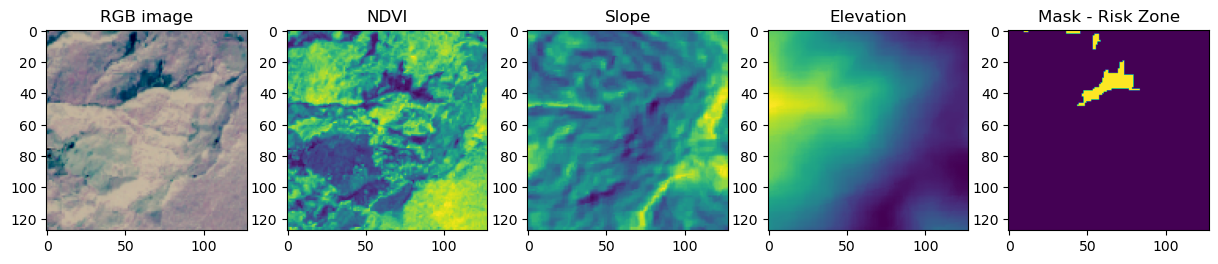

In [198]:
img=221
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask - Risk Zone")
ax1.imshow(TRAIN_XX[img, :, :, 0:3])
ax2.imshow(TRAIN_XX[img, :, :, 3])
ax3.imshow(TRAIN_XX[img, :, :, 4])
ax4.imshow(TRAIN_XX[img, :, :, 5])
ax5.imshow(TRAIN_YY[img, :, :, 0])

### Splitting Training Data into Test in the ration of 80:20

In [174]:
from sklearn.model_selection import train_test_split

# Split the data
x_train, x_valid, y_train, y_valid = train_test_split(TRAIN_XX, TRAIN_YY, test_size=0.2, shuffle= True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


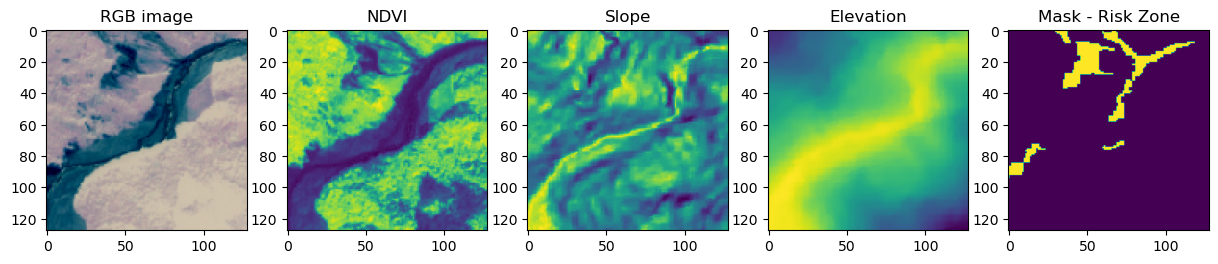

In [187]:
img=185
fig,(ax1,ax2, ax3, ax4, ax5)= plt.subplots(1,5,figsize=(15,10))

ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("Slope")
ax4.set_title("Elevation")
ax5.set_title("Mask - Risk Zone")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(x_train[img, :, :, 5])
ax5.imshow(y_train[img, :, :, 0])

### Final Training Data with 128x128 image of 6 channel , Red , Green , Blue , NDVI , Slope , Elevation for the X and 128x128 with 1 channel of mask for the Y 

In [188]:
x_train.shape, y_train.shape

((3039, 128, 128, 6), (3039, 128, 128, 1))

In [21]:
# to release some memory, delete the unnecessary variable
del TRAIN_XX
del TRAIN_YY
del all_train
del all_mask 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


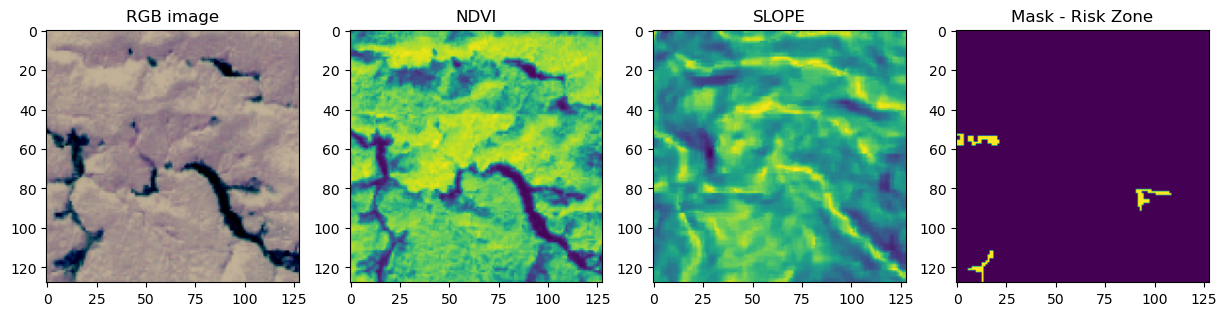

In [22]:
img=1325
fig,(ax1,ax2, ax3, ax4)= plt.subplots(1,4,figsize=(15,10))


ax1.set_title("RGB image")
ax2.set_title("NDVI")
ax3.set_title("SLOPE")
ax4.set_title("Mask - Risk Zone")
ax1.imshow(x_train[img, :, :, 0:3])
ax2.imshow(x_train[img, :, :, 3])
ax3.imshow(x_train[img, :, :, 4])
ax4.imshow(y_train[img, :, :, 0])

### Defining Recall , Precision and F1 score 

## Defining U NET model architecture
### It takes 3 parameters as input , Image Height , Image WIdth and Image Channels and gives a Binnary classification of whether it is landslide risk zone or not 

In [24]:
import tensorflow as tf
from tensorflow.keras import backend as K

# recall 
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# precision
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

#f1 score
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))



def unet_model(IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HIGHT, IMG_CHANNELS))

    # Converted inputs to floating
    #s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)


    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])
    
    return model

model = unet_model(128, 128, 6)
# model.summary()
checkpointer = tf.keras.callbacks.ModelCheckpoint("model_save.h5", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max")
# earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_f1_m', patience=10, verbose=1, mode='max')

callbacks = [
    # earlyStopping,
    checkpointer
    ]
history = model.fit(x_train, y_train, batch_size=16,  
          epochs=25, 
          verbose = 2,
          validation_data=(x_valid, y_valid),
          callbacks=callbacks)

model.save("model_save.h5")

Epoch 1/25

Epoch 1: val_f1_m improved from -inf to 0.47925, saving model to model_save.h5


C:\Users\HP\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


190/190 - 334s - loss: 0.1039 - accuracy: 0.9555 - f1_m: 0.2200 - precision_m: 0.4480 - recall_m: 0.1946 - val_loss: 0.0477 - val_accuracy: 0.9818 - val_f1_m: 0.4792 - val_precision_m: 0.7058 - val_recall_m: 0.3794 - 334s/epoch - 2s/step
Epoch 2/25

Epoch 2: val_f1_m improved from 0.47925 to 0.61539, saving model to model_save.h5
190/190 - 455s - loss: 0.0446 - accuracy: 0.9830 - f1_m: 0.5490 - precision_m: 0.7058 - recall_m: 0.4689 - val_loss: 0.0393 - val_accuracy: 0.9847 - val_f1_m: 0.6154 - val_precision_m: 0.6963 - val_recall_m: 0.5676 - 455s/epoch - 2s/step
Epoch 3/25

Epoch 3: val_f1_m improved from 0.61539 to 0.63654, saving model to model_save.h5
190/190 - 379s - loss: 0.0406 - accuracy: 0.9845 - f1_m: 0.5793 - precision_m: 0.7340 - recall_m: 0.5028 - val_loss: 0.0373 - val_accuracy: 0.9858 - val_f1_m: 0.6365 - val_precision_m: 0.7278 - val_recall_m: 0.5769 - 379s/epoch - 2s/step
Epoch 4/25

Epoch 4: val_f1_m improved from 0.63654 to 0.65553, saving model to model_save.h5
190/

#### Model with accuracy of 98.799 % and Loss of 0.03%

In [25]:
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print(loss, accuracy, f1_score, precision, recall)

0.030254824087023735 0.9879942536354065 0.7105035185813904 0.7681384086608887 0.6640626788139343


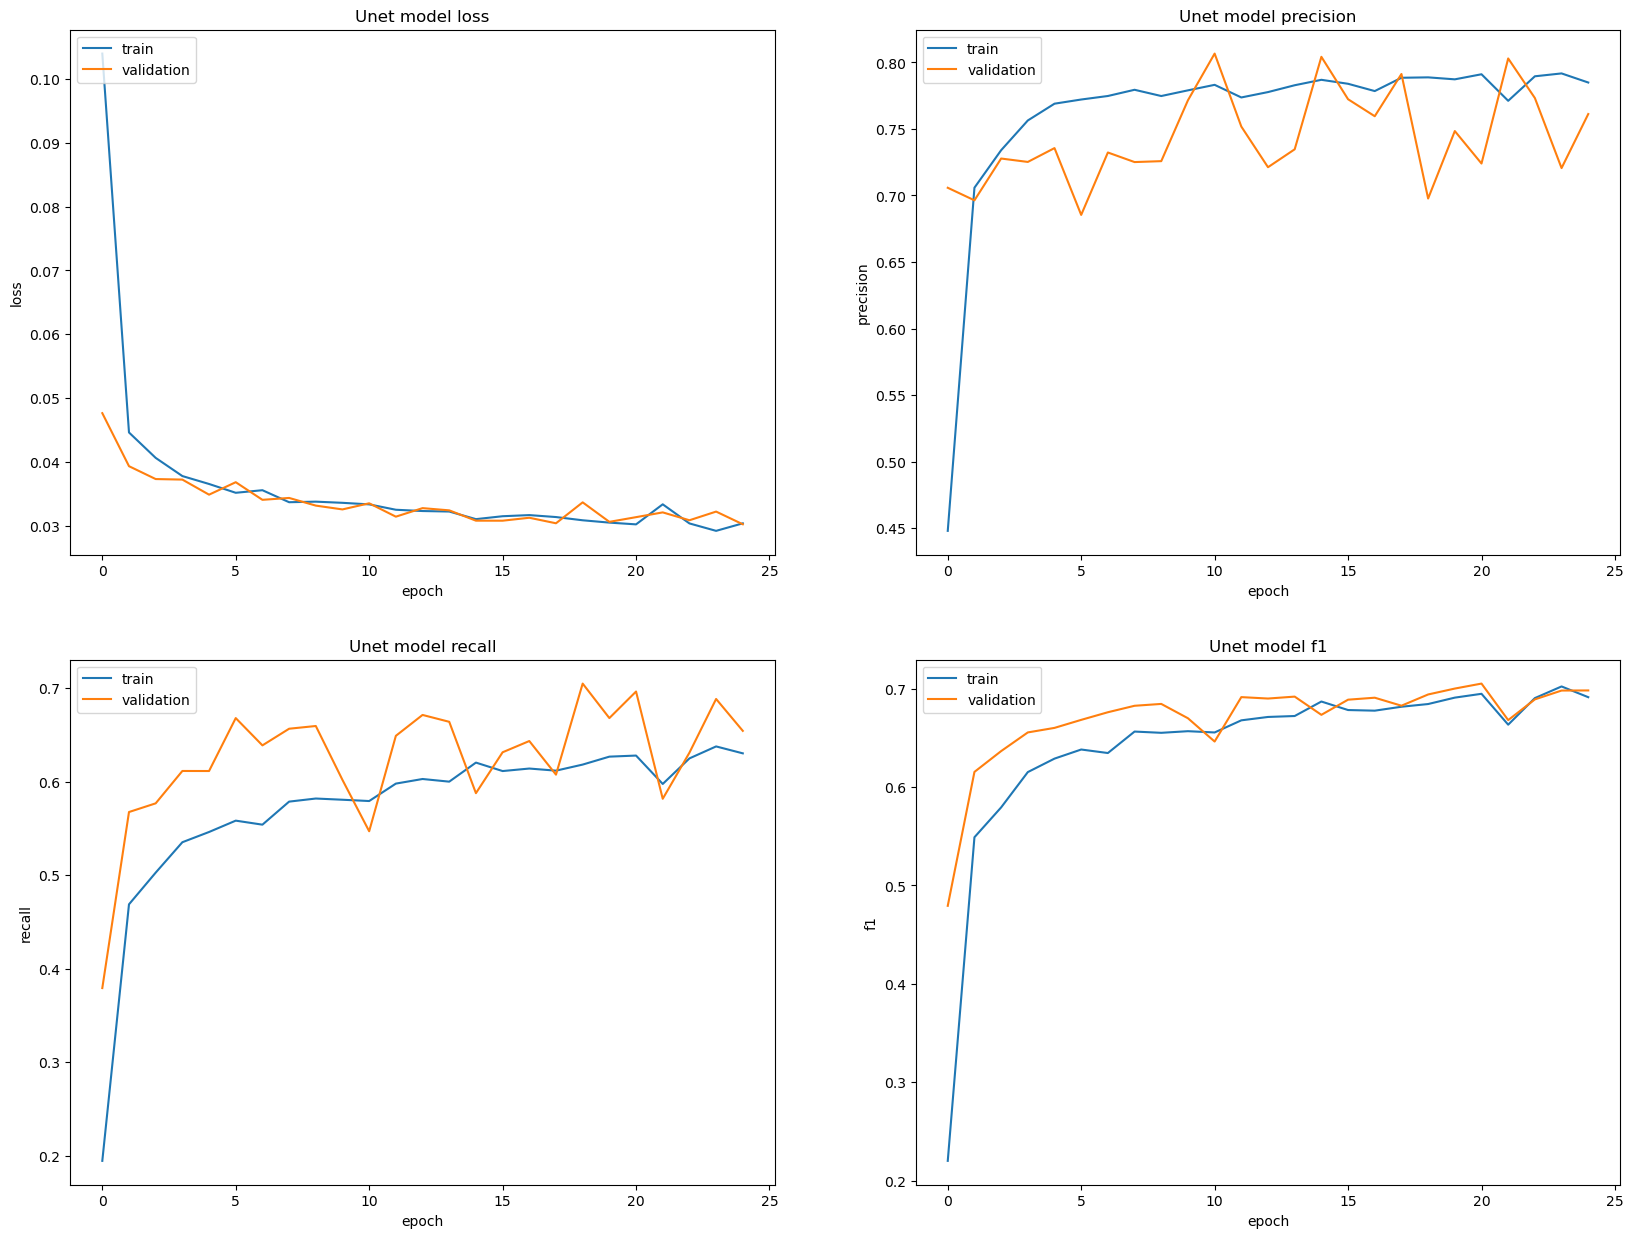

In [26]:
fig,((ax11,ax12),(ax13,ax14)) = plt.subplots(2,2,figsize=(20,15))
ax11.plot(history.history['loss'])
ax11.plot(history.history['val_loss'])
ax11.title.set_text('Unet model loss')
ax11.set_ylabel('loss')
ax11.set_xlabel('epoch')
ax11.legend(['train', 'validation'], loc='upper left')

ax12.plot(history.history['precision_m'])
ax12.plot(history.history['val_precision_m'])
ax12.set_title('Unet model precision')
ax12.set_ylabel('precision')
ax12.set_xlabel('epoch')
ax12.legend(['train', 'validation'], loc='upper left')

ax13.plot(history.history['recall_m'])
ax13.plot(history.history['val_recall_m'])
ax13.set_title('Unet model recall')
ax13.set_ylabel('recall')
ax13.set_xlabel('epoch')
ax13.legend(['train', 'validation'], loc='upper left')

ax14.plot(history.history['f1_m'])
ax14.plot(history.history['val_f1_m'])
ax14.set_title('Unet model f1')
ax14.set_ylabel('f1')
ax14.set_xlabel('epoch')
ax14.legend(['train', 'validation'], loc='upper left')

In [43]:
threshold = 0.21
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

24/24 [==============================] - 23s 945ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Training Image')

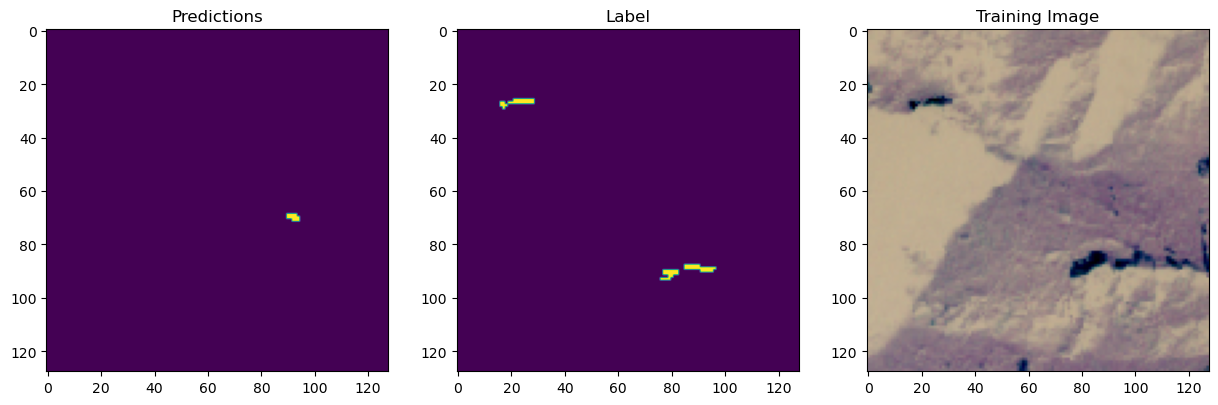

In [105]:
img = 78
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

In [55]:
validation_url = r'DetectionModel/data/ValidData/img/*.h5'
img_val = sorted(glob.glob(validation_url))

VAL_XX = np.zeros((245, 128, 128, 6))
mask_name = []
for i, img in enumerate(img_val):
    print(i, img)
    mask_name.append(img.split('/')[-1].replace('image', 'mask'))
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
        
        # final array
        VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb #RED
        VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        VAL_XX[i, :, :, 3] = data_ndvi #NDVI
        VAL_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope #SLOPE
        VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

0 DetectionModel/data/ValidData/img\image_1.h5
1 DetectionModel/data/ValidData/img\image_10.h5
2 DetectionModel/data/ValidData/img\image_100.h5
3 DetectionModel/data/ValidData/img\image_101.h5
4 DetectionModel/data/ValidData/img\image_102.h5
5 DetectionModel/data/ValidData/img\image_103.h5
6 DetectionModel/data/ValidData/img\image_104.h5
7 DetectionModel/data/ValidData/img\image_105.h5
8 DetectionModel/data/ValidData/img\image_106.h5
9 DetectionModel/data/ValidData/img\image_107.h5
10 DetectionModel/data/ValidData/img\image_108.h5
11 DetectionModel/data/ValidData/img\image_109.h5
12 DetectionModel/data/ValidData/img\image_11.h5
13 DetectionModel/data/ValidData/img\image_110.h5
14 DetectionModel/data/ValidData/img\image_111.h5
15 DetectionModel/data/ValidData/img\image_112.h5
16 DetectionModel/data/ValidData/img\image_113.h5
17 DetectionModel/data/ValidData/img\image_114.h5
18 DetectionModel/data/ValidData/img\image_115.h5
19 DetectionModel/data/ValidData/img\image_116.h5
20 DetectionMo

C:\Users\HP\AppData\Local\Temp\ipykernel_11128\1181495104.py:24: RuntimeWarning: invalid value encountered in divide
  data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))


160 DetectionModel/data/ValidData/img\image_243.h5
161 DetectionModel/data/ValidData/img\image_244.h5
162 DetectionModel/data/ValidData/img\image_245.h5
163 DetectionModel/data/ValidData/img\image_25.h5
164 DetectionModel/data/ValidData/img\image_26.h5
165 DetectionModel/data/ValidData/img\image_27.h5
166 DetectionModel/data/ValidData/img\image_28.h5
167 DetectionModel/data/ValidData/img\image_29.h5
168 DetectionModel/data/ValidData/img\image_3.h5
169 DetectionModel/data/ValidData/img\image_30.h5
170 DetectionModel/data/ValidData/img\image_31.h5
171 DetectionModel/data/ValidData/img\image_32.h5
172 DetectionModel/data/ValidData/img\image_33.h5
173 DetectionModel/data/ValidData/img\image_34.h5
174 DetectionModel/data/ValidData/img\image_35.h5
175 DetectionModel/data/ValidData/img\image_36.h5
176 DetectionModel/data/ValidData/img\image_37.h5
177 DetectionModel/data/ValidData/img\image_38.h5
178 DetectionModel/data/ValidData/img\image_39.h5
179 DetectionModel/data/ValidData/img\image_4.h5

In [189]:
threshold = 0.5
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
pred_img.shape

8/8 [==============================] - 6s 625ms/step


(245, 128, 128, 1)

## Predicting on RGB Image using the trained model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Training Image')

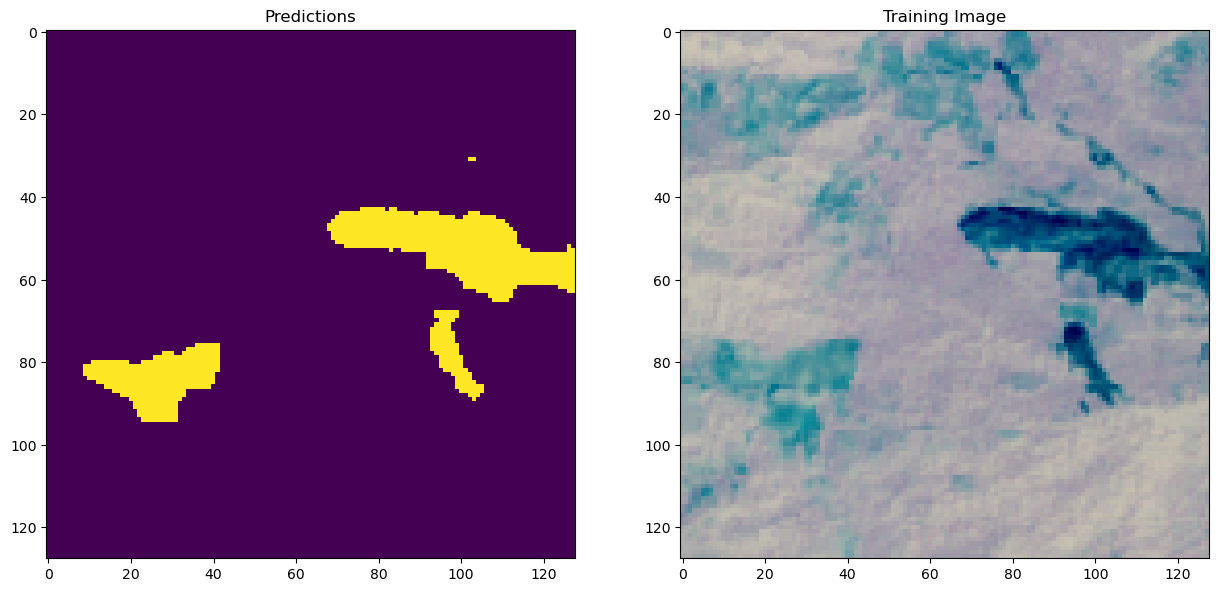

In [206]:
img = 128
fig,(ax1,ax2)= plt.subplots(1,2,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(VAL_XX[img, :, :, 0:3])
ax2.set_title('Training Image')